In [262]:
%pylab inline --no-import-all
import keras
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, ZeroPadding2D, Activation
from keras.callbacks import LambdaCallback
import progressbar

Populating the interactive namespace from numpy and matplotlib


In [365]:
(train, _), (test, _) = mnist.load_data()
train_samples = train.shape[0]
test_samples = test.shape[0]
img_shape = (28*28,)

train = train.reshape((train_samples, *img_shape)) / 255.0
test = test.reshape((test_samples, *img_shape)) / 255.0

In [413]:
encoded_dim = 64  # dimensionality of encoded images

input_layer = Input(shape=img_shape)
encoded_layer = Dense(encoded_dim, activation='relu')(input_layer)
decoded_layer = Dense(img_shape[0], activation='sigmoid')(encoded_layer)


autoencoder = Model(input_layer, decoded_layer)

encoder = Model(input_layer, encoded_layer)

decoder_input = Input(shape=(encoded_dim,))
decoder = Model(decoder_input, autoencoder.layers[-1](decoder_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [414]:
epochs = 20           # epochs count to train the model
log_step = 2          # how frequently plot training results (1 = each epoch)
samples_count = 5     # number of samples to plot
samples = test[(np.random.randint(0, test_samples, size=samples_count))]
f = lambda epoch: int(epoch / log_step) # mapping from epoch number to test number

def plot_test(axes, epoch):
    predictions = (autoencoder.predict(samples[:samples_count]))[:samples_count]
    axes[0, f(epoch)].set_title('epoch ' + str(epoch), size=16)
    for i in range(samples_count):
        axes[i, f(epoch)].imshow(predictions[i].reshape((28, 28)))
        axes[i, f(epoch)].axis('off')

epoch: 20/20 | loss: 0.113813, acc: 0.823316 |###################################################################################################################################################################|

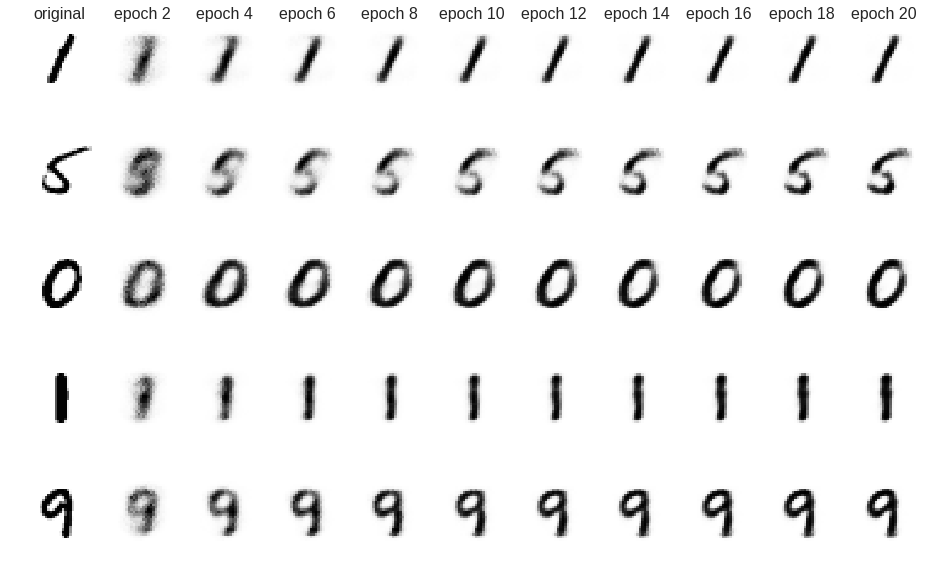

In [415]:
fig, axes = plt.subplots(samples_count, epoch_to_test_num(epochs)+1, figsize=(16, 10))
for i, img in enumerate(samples):
    axes[i, 0].imshow(img.reshape((28, 28)))
    axes[i, 0].axis('off')
    
axes[0, 0].set_title('original', size=16)

val_mapping = {'acc': 0, 'loss': 0}
acc_widget = progressbar.FormatCustomText('loss: %(loss)f, acc: %(acc)f', val_mapping)
bar = progressbar.ProgressBar(max_value=epochs,
                              widgets=['epoch: ', progressbar.Counter(),
                                       '/', str(epochs), ' | ', acc_widget,
                                       ' ', progressbar.Bar()])

def update_progress(epoch):
    val_mapping['loss'], val_mapping['acc'] = autoencoder.evaluate(test[:100], test[:100], verbose=False)
    acc_widget.update_mapping()
    bar.update(epoch)

progress_logger = LambdaCallback(on_epoch_begin=lambda epoch, logs: update_progress(epoch+1))

plot_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: (plot_test(axes, epoch+1)
                                      if (epoch+1) % log_step == 0 and epoch >= (log_step-1) else 0))

autoencoder.fit(train, train,
                batch_size=200, epochs=epochs,
                callbacks=[plot_callback, progress_logger],
                verbose=False)

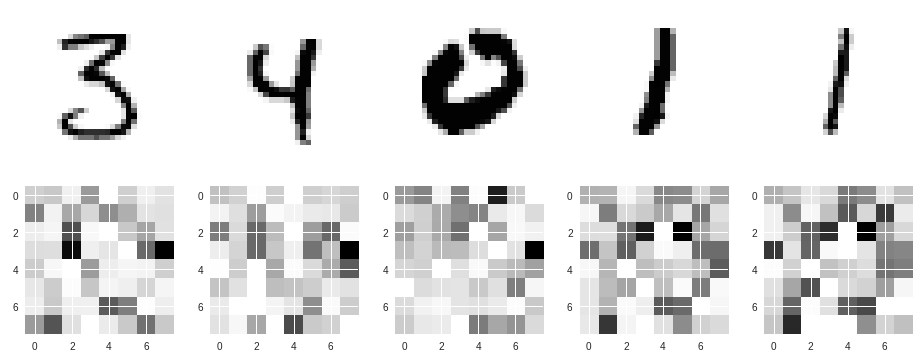

In [416]:
samples_count = 5     # number of samples to plot
samples = test[(np.random.randint(0, test_samples, size=samples_count))]
encoded_samples = encoder.predict(samples)

fig, axes = plt.subplots(2, samples_count, figsize=(16, 6))

for i in range(samples_count):
    axes[0, i].imshow(samples[i].reshape(28, 28))
    axes[0, i].axis('off')
    axes[1, i].imshow(encoded_samples[i].reshape((8, 8)))